In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import parselmouth
from scipy.signal import lfilter, find_peaks

In [2]:
def jitterr(x, sr):
    prd = []
    for i in range(0, len(x) - 2048, 512):
        frame = x[i:i + 2048]
        if np.max(np.abs(frame)) < 0.01:
            continue
        r = np.correlate(frame, frame, 'full')[2048:]
        peak = np.argmax(r[40:200]) + 40
        prd.append(peak / sr)
    return np.mean(np.abs(np.diff(prd))) if len(prd) > 1 else 1e-5


In [3]:
def shimmerr(x):
    amps = [np.max(np.abs(x[i:i+2048])) for i in range(0, len(x)-2048, 512)]
    return np.mean(np.abs(np.diff(amps))) if len(amps) > 1 else 1e-4

In [4]:
def hnr(x):
    hns = []
    for i in range(0, len(x) - 2048, 512):
        f = x[i:i + 2048]
        if np.max(np.abs(f)) < 0.01:
            continue
        r = np.correlate(f, f, 'full')[2048:]
        pk = np.argmax(r[1:200]) + 1
        num = r[pk] + 1e-6
        den = r[0] - r[pk] + 1e-6
        if den <= 0 or num <= 0:
            continue
        h = 10 * np.log10(num / den)
        hns.append(h)
    return np.mean(hns) if hns else 1e-4


In [5]:
def nhr(hnr_val):
    return 1 / (1 + hnr_val) if hnr_val > 0 else 1

In [6]:
def glottal(y, sr, order=16):
    frame = y[0:2048]
    frame = frame * np.hamming(len(frame))
    a = librosa.lpc(y=frame, order=order)
    return lfilter(a, [1.0], frame)

In [7]:
def estimate_open_quotient(glottal, sr):
    peaks, _ = find_peaks(glottal, distance=sr // 400)
    oqs = []
    for i in range(len(peaks) - 1):
        cycle = glottal[peaks[i]:peaks[i + 1]]
        if len(cycle) < 3:
            continue
        d = np.diff(cycle)
        closure_point = np.argmin(d)
        T_closed = len(cycle[:closure_point])
        T_open = len(cycle[closure_point:])
        T_cycle = T_closed + T_open
        if T_cycle > 0:
            oqs.append(T_open / T_cycle)
    return np.mean(oqs) if oqs else 1e-4

In [8]:
def compute_gne(signal, sr):
    gne_vals = []
    for i in range(0, len(signal) - 2048, 512):
        frame = signal[i:i+2048]
        if np.max(np.abs(frame)) < 0.01:
            continue
        r = np.correlate(frame, frame, mode='full')[2048:]
        pk = np.argmax(r[1:200]) + 1
        gne = r[pk] / (r[0] + 1e-6)
        gne_vals.append(gne)
    return np.mean(gne_vals) if gne_vals else 1e-4

In [9]:
def compute_vfer(y, sr):
    frame_length = max(int(0.05 * sr), int(sr / 75 * 2))  # Minimum 2 cycles of 75 Hz
    hop_length = int(0.02 * sr)

    f0, voiced_flag, _ = librosa.pyin(y, fmin=75, fmax=300, sr=sr, frame_length=frame_length, hop_length=hop_length)
    frames = range(0, len(y) - frame_length, hop_length)
    energy = [np.sum(y[i:i + frame_length] ** 2) for i in frames]
    min_len = min(len(energy), len(voiced_flag))
    voiced_flag = voiced_flag[:min_len]
    energy = energy[:min_len]

    vfer_framewise = []
    for i in range(min_len):
        voiced_energy = energy[i] if voiced_flag[i] else 0
        total_energy = energy[i]
        vfer = voiced_energy / (total_energy + 1e-6)
        vfer_framewise.append(vfer)

    return np.mean(vfer_framewise) if vfer_framewise else 1e-4


In [10]:
def vtl(audio_path):
    try:
        snd = parselmouth.Sound(audio_path)
        formant = snd.to_formant_burg(time_step=0.01, max_number_of_formants=5, maximum_formant=5500)
        times = formant.ts()
        f1_values = [formant.get_value_at_time(1, t) for t in times if formant.get_value_at_time(1, t) and 250 < formant.get_value_at_time(1, t) < 1000]
        if len(f1_values) == 0:
            return 1e-4
        avg_f1 = np.mean(f1_values)
        return round(35000 / (4 * avg_f1), 2)
    except:
        return 1e-4


In [11]:
def extract_f0_f1_f2_f3(audio_path):
    try:
        snd = parselmouth.Sound(audio_path)

        pitch = snd.to_pitch_ac(time_step=0.01, voicing_threshold=0.6)
        f0_values = pitch.selected_array['frequency']
        f0_values = f0_values[f0_values > 50]
        f0 = np.mean(f0_values) if len(f0_values) > 0 else 0

        formant = snd.to_formant_burg(time_step=0.01, max_number_of_formants=5, maximum_formant=5500)
        times = formant.ts()
        f1_list, f2_list, f3_list = [], [], []

        for t in times:
            f1 = formant.get_value_at_time(1, t)
            f2 = formant.get_value_at_time(2, t)
            f3 = formant.get_value_at_time(3, t)
            if 250 < f1 < 1000:
                f1_list.append(f1)
            if 800 < f2 < 3000:
                f2_list.append(f2)
            if 2000 < f3 < 4000:
                f3_list.append(f3)

        return {
            "F0": round(np.mean(f0_values), 2) if len(f0_values) else 0,
            "F1": round(np.mean(f1_list), 2) if f1_list else 0,
            "F2": round(np.mean(f2_list), 2) if f2_list else 0,
            "F3": round(np.mean(f3_list), 2) if f3_list else 0,
        }

    except Exception as e:
        print(f"Error in extract_f0_f1_f2_f3: {e}")
        return {"F0": 0, "F1": 0, "F2": 0, "F3": 0}

In [12]:
import os
import numpy as np
import pandas as pd
import librosa

def extract_all_features_to_csv(base_path="/Users/manyasharma/FINAL_PROJECT_(POLYP)/", output_csv="/Users/manyasharma/FINAL_PROJECT_(POLYP)/acoustic_features1.csv"):
    genders = {"Healthy": 1, "Polyp": 0}
    feature_list = []

    for gender_name, label in genders.items():
        folder = os.path.join(base_path, gender_name)
        for file in os.listdir(folder):
            if file.endswith(".wav"):
                path = os.path.join(folder, file)
                try:
                    y, sr = librosa.load(path, sr=None)
                    glott = glottal(y, sr)
                    formant_data = extract_f0_f1_f2_f3(path)  

                    feature_list.append([
                        jitterr(y, sr),
                        shimmerr(y),
                        hnr(y),                                 
                        nhr(hnr(y)),
                        vtl(path),                              
                        compute_vfer(y, sr),                    
                        compute_gne(y, sr),                     
                        estimate_open_quotient(glott, sr),
                        formant_data["F0"],                     
                        formant_data["F1"],                     
                        formant_data["F2"],
                        formant_data["F3"],                     
                        label                                   
                    ])

                except Exception as e:
                    print(f"Error processing {file}: {e}")
                    continue

    columns = ["Jitter", "Shimmer", "HNR", "NHR", "VTL", "VFER", "GNE", "GQ", "F0", "F1", "F2", "F3", "Label"]
    df = pd.DataFrame(feature_list, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"CSV saved at: {output_csv}")

In [13]:
extract_all_features_to_csv()

CSV saved at: /Users/manyasharma/FINAL_PROJECT_(POLYP)/acoustic_features1.csv


In [14]:
df = pd.read_csv("/Users/manyasharma/FINAL_PROJECT_(POLYP)/acoustic_features1.csv")
y = df['Label']
X = df.drop('Label', axis=1)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (447, 12)
Test size: (112, 12)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", "auto", 0.01, 0.001],
    "kernel": ["rbf", "linear"]
}

grid = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.7674656679151062


In [18]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", C=10, gamma="auto", probability=True)
model.fit(X_train_scaled, y_train)

SVC(C=10, gamma='auto', probability=True)

Confusion Matrix:
 [[44 12]
 [ 9 47]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.83      0.79      0.81        56
       Polyp       0.80      0.84      0.82        56

    accuracy                           0.81       112
   macro avg       0.81      0.81      0.81       112
weighted avg       0.81      0.81      0.81       112



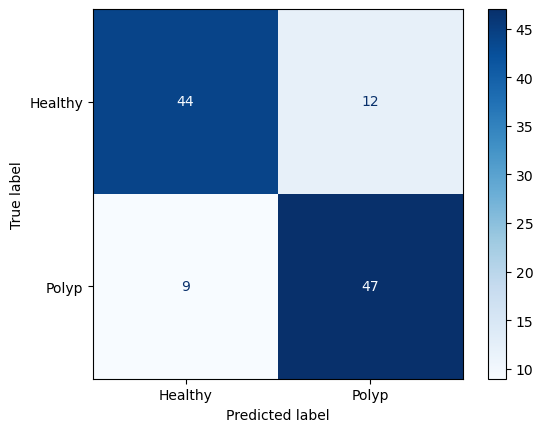

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Healthy","Polyp"]))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Polyp"])
disp.plot(cmap="Blues", values_format="d")